In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


Feedforward neural networks are really good at pattern recognition. A ConvNet, for example, can precisely classify a video frame by looking at edges, colors, textures, and more. By design, however, feedforward networks treat the inputs as if they are independent; the ConvNet doesn't really know how to use the classification of a video frame to improve its reasoning for the next one. This presents a problem for many tasks where data dependencies happen naturally and in a meaningful way such as speech recognition, image captioning, or time series prediction. Fortunately, there are deep learning architectures that use memory cells and really shine in these areas: recurrent neural networks.

### Recurrent Neural Network (RNN)

Recurrent Neural Networks (RNNs) differ from their feedforward counterparts in their use of memory cells. A memory cell holds a hidden state that changes over time. A cell's hidden state at time step $t$, denoted by $h(t)$, is a function of some inputs at that time step $x_t$ and its state at the previous time step $h_{t - 1}$, i.e. $h_t = f(x_t, h_{t - 1})$. Since the memory cell sends the output back to itself, it is considered to have some form of memory and hence the name recurrent networks. 

<img src="images/recurrent-neural-networks/rnn.png" style='width:30%'>

[Figure 1](#fig:rnn) shows a compact representation of a RNN with three hidden layers and its unrolled representation through time. The output of the memory cell at time step $t$ is a function of its hidden state. For example, a vanilla RNN can be formulated using $h_t = \tanh(W_{hh}h_{t - 1} + W_{xh}x_{t})$ and $y_t = W_{hy}h_t$.

Unlike feedforward neural networks, RNNs offer a lot more flexibility by allowing inputs and outputs to have arbitrary lengths. An unrolled RNN can be as long as their inputs to capture long-term patterns such as those found in texts. As other deep nets, however, these deep RNNs will significantly suffer from the vanishing or exploding gradients problem. The reason is that the output at time step $t$ depends on all of the previous time steps, but the gradients can't flow backward in time due to repeated matrix multiplication with the chain rule.

### Long Short-Term Memory (LSTM)

The Long Short-Term Memory (LSTM) networks solve this problem by using a clever mechanism. Not only does a LSTM maintain a short-term state $h_t$ as in vanilla RNNs, it also has a long-term state $c_t$ as a super highway through time that allows the gradients to easily flow backward. A LSTM uses a gating mechanism to control its cell states. As the long-term state $c_{t - 1}$ traverses through time, it goes through a forget gate to drop some memories and through an input gate to add some new ones. The new value $c_t$ is passed through the $\tanh$ function and filtered by an output gate to produce a new output $h_t$ for the short-term state. The whole process is demonstrated in [Figure 2](#fig:lstm).

<img src="images/recurrent-neural-networks/lstm.jpg" style='width:35%'>

It might be easier to follow the digram with the following equations:

$$
\begin{aligned}
g_t &= \tanh(\mathbf{W}^{cx} x_t + \mathbf{W}^{ch} h_{t - 1} + b^c), \\
i_t &= \sigma(\mathbf{W}^{ix} x_t + \mathbf{W}^{ih} h_{t - 1} + b^i), \\
f_t &= \sigma(\mathbf{W}^{fx} x_t + \mathbf{W}^{fh} h_{t - 1} + b^f), \\
c_t &= f_t \otimes c_{t - 1} + i_t \otimes g_t, \\
o_t &= \sigma(\mathbf{W}^{ox} x_t + \mathbf{W}^{oh} h_{t - 1} + b^o), \\
h_t &= o_t \otimes \tanh(c_t).
\end{aligned}
$$

In these equations, $\sigma$ and $\tanh$ denote the sigmoid and tanh activation function, respectively, and $\otimes$ denotes elementwise multiplication. The important point here is that while a vanilla RNN always outputs the main layer $g_t$, a LSTM learns to extract some important part of $g_t$ via the input gate controlled by $i_t$ and combine it with the previous long-term state via the forget gate controlled by $f_t$. That explains why LSTMs are capable of capturing long-term dependencies beyond the reach of vanilla RNNs.


### Generate Fake Tweets

To demonstrate the effectiveness of LSTM, we will follow [the fun post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) of [Andej Karparthy](https://cs.stanford.edu/people/karpathy/) and his char-RNN model. The dataset that we will use comes from [Trump Twitter Archive](http://www.trumptwitterarchive.com/archive), which consists of 32,782 tweets (about 3.5 MB) from the president of United States up until December 29, 2017.

The goal here is to predict the next character in a sequence given all of the previous characters. Since our machines have limited memory, we will split the whole dataset into many sequences of 50 characters and feed them into a LSTM one a time. During training, we let the target for a sequence simply be the sequence shifted one time step to the right. During testing, we provide the LSTM a seed sequence containing 50 characters, append the predicted character to the sequence, feed the last 50 characters to the LSTM to predict the next character, and so on. Hopefully, the neural network will generate a sequence of characters that bear some resemblance to the input tweets.

We will use a LSTM with 3 layers of 256 neurons each. Given a vocabulary of characters, the LSTM simultaneously learns the vector representations of these characters and the variables within the LSTM cells.

In [2]:
import codecs
import collections

class TextLoader():
    def __init__(self, input_file, batch_size, seq_length, encoding='utf-8'):
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.encoding = encoding

        self.preprocess(input_file)
        self.create_batches()
        self.reset_batch_pointer()

    def preprocess(self, input_file):
        with codecs.open(input_file, "r", encoding=self.encoding) as f:
            data = f.read()
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        self.decoder = {value: key for key, value in self.vocab.items()}
        self.tensor = np.array(list(map(self.vocab.get, data)))


    def create_batches(self):
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))
        if self.num_batches == 0:
            assert False, "Not enough data. Make seq_length and batch_size small."

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
        xdata = self.tensor
        ydata = np.copy(self.tensor)
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]
        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)

    def next_batch(self):
        x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
        self.pointer += 1
        return x, y

    def reset_batch_pointer(self):
        self.pointer = 0

        
input_file = '../datasets/tweets.txt'
batch_size = 128
seq_length = 50

train_data = TextLoader(input_file, batch_size, seq_length)
vocab_size = train_data.vocab_size

In [4]:
num_layers = 3
num_units = 256
cell_fn = tf.contrib.rnn.BasicLSTMCell

tf.reset_default_graph()
tf.set_random_seed(42)
    
X = tf.placeholder(tf.int32, shape=[None, seq_length])
y = tf.placeholder(tf.int32, shape=[None, seq_length])
keep_prob = tf.placeholder_with_default(1.0, shape=())
batch_size = tf.placeholder_with_default(1, shape=())

embedding = tf.get_variable('embedding', [vocab_size, num_units])
inputs = tf.nn.embedding_lookup(embedding, X)

cells = [cell_fn(num_units) for layer in range(num_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob) for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)

initial_state = multi_layer_cell.zero_state(batch_size, dtype=tf.float32)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, inputs, initial_state=initial_state)

outputs = tf.reshape(rnn_outputs, [-1, num_units])
logits = tf.layers.dense(outputs, vocab_size)
y_proba = tf.nn.softmax(logits)

y_reshaped = tf.reshape(y, [-1])
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped))

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5)
training_op = optimizer.apply_gradients(zip(gradients, variables))

correct = tf.nn.in_top_k(logits, y_reshaped, k=1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
from datetime import datetime

num_epoch = 1000
num_chars = 500

sess = tf.Session()
sess.run(init)

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

for epoch in range(num_epoch):
    avg_loss = avg_acc = 0
    train_data.reset_batch_pointer()
    
    last_states = None    
    for iteration in range(train_data.num_batches):
        X_batch, y_batch = train_data.next_batch()
        feed_dict = {X: X_batch, y: y_batch, keep_prob: 0.85, batch_size: 128}
        if last_states is not None:
            feed_dict[initial_state] = last_states
        _, last_states, train_loss, train_acc = sess.run([training_op, states, loss, accuracy], feed_dict)
            
        avg_loss += train_loss / train_data.num_batches
        avg_acc += train_acc / train_data.num_batches
    print('[%s] Epoch %d: train loss = %.6f, train accuracy = %.6f' % (datetime.now(), epoch, avg_loss, avg_acc))
    
    if avg_loss < best_loss:
        save_path = saver.save(sess, "/tmp/rnn/tweets.ckpt")
        best_loss = avg_loss
        checks_without_progress = 0
    else:
        checks_without_progress += 1
        if checks_without_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    sequences = [0 for i in range(seq_length)]
    for sample in range(num_chars - seq_length):
        X_batch = np.array(sequences[-seq_length:]).reshape(1, seq_length)
        y_proba_val = sess.run(y_proba, feed_dict={X: X_batch})
        sequences.append(np.random.choice(vocab_size, p=y_proba_val[-1, :]))
    print(''.join([train_data.decoder[char] for char in sequences[seq_length:]]))
    print('')

<style>
.well {
    min-height: 20px;
    padding: 19px;
    margin-bottom: 20px;
    background-color: #f5f5f5;
    border: 1px solid #e3e3e3;
    border-radius: 4px;
    -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, .05);
    box-shadow: inset 0 1px 1px rgba(0, 0, 0, .05)
}
.well blockquote {
    border-color: #ddd;
    border-color: rgba(0, 0, 0, .15)
}
.well-lg {
    padding: 24px;
    border-radius: 6px
}
.well-sm {
    padding: 9px;
    border-radius: 3px
}
</style>

At the end of the first epoch, it outputs some random gibberish:
<div class="well">
@was as. "ham Eirc; Ciliir a goke I  "Te.in anSir in le unp: soan aeGy8@hlenfanchle 1DMtoth likes sy-Genk ryin lurinr we Aca - fout4vot ce tere fatp!nes Soden!s"o rociy Uarkd#."F"-b
pes raunore
tuas  ""recy Mixpa anenlroon is womircal GEid vitor.Mp.jont L: buci A Vedam maninotge/Jar suweah
</div>

By the end of the second epoch, the LSTM knows how to address some people with @Sherksandam and @Jaig501 (of course, these are fake usernames), or call for attention with a hashtag #DonaldTrump. Although there are many spelling errors, it has managed to get quite a few short words correctly. We also see some evidence that the neural network is capable of placing periods and capitalizing the first letters after periods.

<div class='well'>
Aberica and we aU's pevideon heart.
. Tweets"
If for loing on Sunday the os Yund returnan THN
"@omsaleavy are visian.
Oploke. How for Call RemieStease when doing. Pigxs American So resly waste has wall from over never...
@Jaig501 #DonaldTrump watcting plaecidents forper!"
“He’s faelf and cat.
</div>

After 5 epochs, longer words appear and it sounds a lot more like English. The LSTM also sneaks in a fake link to look more legitimate. We still don't understand what it's rambling about yet, which is fine since that's probably the last thing we would expect.

<div class='well'>
Memoriots can knew) will be statement primary in the besting River Obama during used to run for high in Veg Awards Ehonigo 7 more when. #Trump2016 <a href='https://t.co/6fYdANMsKfY'>https://t.co/6fYdANMsKfY</a>) via @coedimpGMoz then with @realDonaldTrump all your beautiful with a come feel agree ‘night at 9:55 P.M. CNN was given on the crised out conference ziggers in me act more
</div>

The training goes on, and the loss stops decreasing after 80 epochs. At this point, long hashtags emerge and the generated texts seem to have more meaning. More importantly, it sounds a lot more like Trump! My favorite part of the generated texts is the party popper emoji, which actually happens only twice in the whole dataset.

<div class='well'>
I may be innocent to Russian we’d quite that's their coming list! Ordania didn't know that Jobs Please Crooked Hillary advice for Obama. #CelebrityApprentice. Don't reporting some man fan $500M to run for President” Think Big. Hame to knows says uss I am so great! @realDonaldTrump the best during 2016. #MakeAmericaGreatAgain!!!! 🎉 very success! <a href='http://t.co/LnmL3TZPcD'>http://t.co/LnmL3TZPcD</a>.
</div>

With better hyperparameter tuning and longer training time, the LSTM probably can produce texts with more reasonable fidelity. However, we get the idea that LSTMs can make sense of long-term dependencies in natural language and provide quite simple generative models.

### Learn to Add Numbers

We will now train a LSTM to add 5-digits numbers, but we won't even let it know they are numbers. The challenge for the LSTM is to take in a sequence of characters, such as `34135 + 67013`, and return a correct answer, given a dataset consisting of similar sequences and corresponding solutions.

In the previous example, there is a one-to-one mapping between a character in the input to a character in the output. In this example, the output doesn't necessarily have the same length as the input if there is a carry. Fortunately, the problem fits perfectly into the framework of sequence to sequence learning, where we can have an LSTM encoder that transforms an input sequence into an internal state and a LSTM decoder that converts the internal state to an output sequence (see [Figure 3](#fig:seq2seq)). The technique has been successfully applied to [neural machine translation](https://arxiv.org/pdf/1409.0473.pdf).

<img src="images/recurrent-neural-networks/seq2seq.png" style='width:50%'>
Figure 3: A sequence to sequence approach to the math problem. In this case, the encoder and decoder are two distinct LSTMs that are connected via their internal states. The inputs the decoder are prepended with 'GO' to signal their beginnings. Similarly, the outputs of the decoder are appended with 'END' to indicate their endings.

In [8]:
training_size = 250000
num_digits = 5
X_length = 2 * num_digits + 1
y_length = num_digits + 1
X_vocab_size = 12
y_vocab_size = 11

f = lambda(x): int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, x + 1))))
X_raw = ['{0:>5}+{1:>5}'.format(f(num_digits), f(num_digits)) for _ in range(training_size)]
y_raw = ['{0:>6}'.format(str(eval(x))) for x in X_raw]

def one_hot_encoding(string, vocab, max_length):
    char_to_idx = {char: idx for idx, char in enumerate(vocab)}
    one_hot = np.zeros((max_length, len(vocab)))
    
    for i, char in enumerate(string):
        one_hot[i, char_to_idx[char]] = 1
    return one_hot

def one_hot_decoding(vector, vocab):
    idx_to_char = {idx: char for idx, char in enumerate(vocab)}
    return ''.join([idx_to_char[np.argmax(row)] for row in vector])

encode_inputs = lambda (x): one_hot_encoding(x, vocab='0123456789+ ', max_length=X_length)
encode_targets = lambda (y): one_hot_encoding(y, vocab='0123456789 /', max_length=y_length + 1)

decode_inputs = lambda (x): one_hot_decoding(x, vocab='0123456789+ ')
decode_targets = lambda (y): one_hot_decoding(y, vocab='0123456789 /')

X = np.array([encode_inputs(x) for x in X_raw])
y0 = np.array([encode_targets('/' + y) for y in y_raw])
y1 = np.array([encode_targets(y + '/') for y in y_raw])

from sklearn.model_selection import train_test_split
X_train, X_test, y0_train, y0_test, y1_train, y1_test = train_test_split(X, y0, y1, test_size=0.2, random_state=42)
X_train.shape, y0_train.shape, y1_train.shape, X_test.shape, y0_test.shape, y1_test.shape

((200000, 11, 12),
 (200000, 7, 12),
 (200000, 7, 12),
 (50000, 11, 12),
 (50000, 7, 12),
 (50000, 7, 12))

In [9]:
num_layers = 1
num_units = 256
batch_size = 128
learning_rate = 0.01

tf.reset_default_graph()
tf.set_random_seed(42)
    
encoder_inputs = tf.placeholder(tf.float32, shape=[None, X_length, X_vocab_size])
decoder_inputs = tf.placeholder(tf.float32, shape=[None, y_length + 1, y_vocab_size + 1])
decoder_targets = tf.placeholder(tf.int32, shape=[None, y_length + 1, y_vocab_size + 1])
keep_prob = tf.placeholder_with_default(1.0, shape={})

encoder_cells = [tf.contrib.rnn.BasicLSTMCell(num_units) for layer in range(num_layers)]
dropout_cells = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob) for cell in encoder_cells]
encoder_multi_cell = tf.contrib.rnn.MultiRNNCell(encoder_cells)
encoder_outputs, encoder_states = tf.nn.dynamic_rnn(encoder_multi_cell, encoder_inputs, dtype=tf.float32, scope='encoder')

decoder_cells = [tf.contrib.rnn.BasicLSTMCell(num_units) for layer in range(num_layers)]
decoder_multi_cell = tf.contrib.rnn.MultiRNNCell(decoder_cells)
decoder_outputs, decoder_states = tf.nn.dynamic_rnn(decoder_multi_cell, decoder_inputs, initial_state=encoder_states, scope='decoder')
logits = tf.layers.dense(decoder_outputs, y_vocab_size + 1)
prediction = tf.one_hot(tf.argmax(logits, axis=2), depth=y_vocab_size + 1, dtype=tf.int32)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=decoder_targets))
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5)
training_op = optimizer.apply_gradients(zip(gradients, variables))

init = tf.global_variables_initializer()
saver = tf.train.Saver()


Both the LSTM encoder and the LSTM decoder that we use have one layer with 256 neurons. To fight against overfitting and aid generalization, we apply 50% dropout. After 50 epochs, the model achieves more than 99% accuracy for both the training set and the validation set. At this point, it is able to correctly perform new additions with multiple carries such as `57826 + 44397 = 102223` or `98241 + 79869 = 178110`. This is quite remarkable given that it learns everything from scratch. With a new set of 10,000 additions, it makes only 24 mistakes (99.76% accuracy). The following table shows 10 of those mistakes. As you can see, these mistakes are all off-by-one errors. It's interesting that most of the wrong answers are due to overestimation, although it's not clear why.

In [11]:
from datetime import datetime

num_epoch = 1000
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

train_batches = len(X_train) // batch_size
test_batches = len(X_test) // batch_size

sess = tf.Session()
sess.run(init)
for epoch in range(num_epoch):
    perm = np.random.permutation(len(X_train))
    X_train, y0_train, y1_train = X_train[perm], y0_train[perm], y1_train[perm]

    total_train_loss = total_train_acc = 0
    for iteration in range(train_batches):
        X_batch = X_train[iteration * batch_size: (iteration + 1) * batch_size, :, :]
        y0_batch = y0_train[iteration * batch_size: (iteration + 1) * batch_size, :, :]
        y1_batch = y1_train[iteration * batch_size: (iteration + 1) * batch_size, :, :]
        feed_dict = {encoder_inputs: X_batch, decoder_inputs: y0_batch, decoder_targets: y1_batch, keep_prob: 0.5}

        _, train_loss, predicted = sess.run([training_op, loss, prediction], feed_dict=feed_dict)
        total_train_loss += train_loss
        total_train_acc += np.sum([np.all(np.equal(u, v)) for u, v in zip(y1_batch, predicted)])

    avg_train_loss = total_train_loss / len(X_train)
    avg_train_acc = 1.0 * total_train_acc / len(X_train)

    total_test_loss = total_test_acc = 0
    for iteration in range(test_batches):
        X_batch = X_test[iteration * batch_size: (iteration + 1) * batch_size, :, :]
        y0_batch = y0_test[iteration * batch_size: (iteration + 1) * batch_size, :, :]
        y1_batch = y1_test[iteration * batch_size: (iteration + 1) * batch_size, :, :]
        feed_dict = {encoder_inputs: X_batch, decoder_inputs: y0_batch, decoder_targets: y1_batch}

        test_loss, predicted = sess.run([loss, prediction], feed_dict=feed_dict)
        total_test_loss += test_loss
        total_test_acc += np.sum([np.all(np.equal(u, v)) for u, v in zip(y1_batch, predicted)])

    avg_test_loss = total_test_loss / len(X_test)
    avg_test_acc = 1.0 * total_test_acc / len(X_test)

    print('[%s] Epoch %d: train loss = %.6f, test loss = %.6f, train accuracy = %.6f, test accuracy = %.6f' % 
          (datetime.now(), epoch, avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc))

    if avg_test_loss < best_loss:
        save_path = saver.save(sess, "/tmp/rnn/math.ckpt")
        best_loss = avg_test_loss
        checks_without_progress = 0
    else:
        checks_without_progress += 1
        if checks_without_progress > max_checks_without_progress:
            print("Early stopping!")
            break

[2018-01-02 09:23:35.565044] Epoch 0: train loss = 0.007572, test loss = 0.005093, train accuracy = 0.044325, test accuracy = 0.122160
[2018-01-02 09:24:42.904611] Epoch 1: train loss = 0.004184, test loss = 0.003583, train accuracy = 0.225945, test accuracy = 0.294360
[2018-01-02 09:25:50.070616] Epoch 2: train loss = 0.002612, test loss = 0.001993, train accuracy = 0.452490, test accuracy = 0.549620
[2018-01-02 09:26:57.193048] Epoch 3: train loss = 0.001360, test loss = 0.001065, train accuracy = 0.670805, test accuracy = 0.709220
[2018-01-02 09:28:05.020364] Epoch 4: train loss = 0.000627, test loss = 0.000480, train accuracy = 0.825035, test accuracy = 0.861340
[2018-01-02 09:29:12.604330] Epoch 5: train loss = 0.000415, test loss = 0.000319, train accuracy = 0.880415, test accuracy = 0.908000
[2018-01-02 09:30:19.984122] Epoch 6: train loss = 0.000315, test loss = 0.000287, train accuracy = 0.908765, test accuracy = 0.914720
[2018-01-02 09:31:27.820158] Epoch 7: train loss = 0.00

[2018-01-02 10:31:59.881561] Epoch 61: train loss = 0.000026, test loss = 0.000024, train accuracy = 0.993230, test accuracy = 0.992920
[2018-01-02 10:33:07.206569] Epoch 62: train loss = 0.000033, test loss = 0.000017, train accuracy = 0.992490, test accuracy = 0.994020
[2018-01-02 10:34:14.745183] Epoch 63: train loss = 0.000020, test loss = 0.000056, train accuracy = 0.995190, test accuracy = 0.985540
[2018-01-02 10:35:21.779642] Epoch 64: train loss = 0.000025, test loss = 0.000031, train accuracy = 0.994085, test accuracy = 0.992880
[2018-01-02 10:36:29.476424] Epoch 65: train loss = 0.000041, test loss = 0.000016, train accuracy = 0.990770, test accuracy = 0.994920
Early stopping!


In [14]:
saver.restore(sess, save_path)

sess = tf.Session()
saver.restore(sess, '/tmp/rnn/math.ckpt')
prediction_val = sess.run(prediction, feed_dict={encoder_inputs: X_train, decoder_inputs: y0_train})
correct = np.sum([np.all(np.equal(sol, ans)) for sol, ans in zip(y1_train, prediction_val)])
print('Accuracy = %.6f' % (1.0 * correct / len(prediction_val)))

for eq, sol, ans in zip(X_train, y1_train, prediction_val)[:1000]:
    if not np.all(np.equal(ans, sol)):
        print('%s = %s (correct = %s)' % (decode_inputs(eq), decode_targets(ans), decode_targets(sol)))

INFO:tensorflow:Restoring parameters from /tmp/rnn/math.ckpt
INFO:tensorflow:Restoring parameters from /tmp/rnn/math.ckpt
Accuracy = 0.997280
  212+ 4306 =   4508/ (correct =   4518/)
66731+  949 =  67670/ (correct =  67680/)
 9165+45689 =  54844/ (correct =  54854/)
 6995+69696 =  76791/ (correct =  76691/)


In [16]:
def test_addition(numbers=None, test_size=10000, verbose=False):
    if numbers is None:
        numbers = [(f(num_digits), f(num_digits)) for _ in range(test_size)]
    X_new = ['{0:>5}+{1:>5}'.format(a, b) for (a, b) in numbers]
    y_new = ['{0:>6}'.format(str(eval(x))) for x in X_new]

    X_new_encoded = np.array([encode_inputs(x) for x in X_new])
    y_new_encoded = np.array([encode_targets('/' + y) for y in y_new])

    prediction_val = sess.run(prediction, feed_dict={encoder_inputs: X_new_encoded, decoder_inputs: y_new_encoded})
    decoded_ans = [decode_targets(x) for x in prediction_val]

    correct = sum([sol == ans[:-1] for sol, ans in zip(y_new, decoded_ans)])
    print('Accuracy = %.6f' % (1.0 * correct / test_size))

    for eq, sol, ans in zip(X_new, y_new, decoded_ans):
        if verbose:
            print('%s = %s (%scorrect)' % (eq, ans[:-1], '' if ans[:-1] == sol else 'in'))
        elif ans[:-1] != sol:
            print('%s = %s (incorrect)' % (eq, ans[:-1]))
            
test_addition()

Accuracy = 0.994800
97143+85000 = 182043 (incorrect)
13760+71455 =  75215 (incorrect)
  893+  314 =   1107 (incorrect)
97210+  629 =  97829 (incorrect)
   11+ 5914 =   5935 (incorrect)
   58+55642 =  53700 (incorrect)
81364+38094 = 119448 (incorrect)
80421+80790 = 162211 (incorrect)
 7152+ 7293 =  14435 (incorrect)
10310+60113 =  70433 (incorrect)
21693+ 1774 =  23367 (incorrect)
 4797+41996 =  46893 (incorrect)
 5110+74629 =  79729 (incorrect)
89723+    8 =  89732 (incorrect)
89393+ 8602 =  97994 (incorrect)
 4670+17994 =  22654 (incorrect)
22302+15033 =  37325 (incorrect)
 9638+39972 =  49710 (incorrect)
25980+18868 =  45848 (incorrect)
 1984+ 9477 =  11451 (incorrect)
 5584+ 7898 =  13472 (incorrect)
57065+64045 = 121100 (incorrect)
  179+ 5026 =   5105 (incorrect)
91101+ 9009 = 100020 (incorrect)
  694+18426 =  19110 (incorrect)
82423+91624 = 173047 (incorrect)
51803+78902 = 140705 (incorrect)
 3861+60930 =  64781 (incorrect)
49692+ 7973 =  57765 (incorrect)
40049+72508 = 112567 (i

In [17]:
test_size = 100
X_new = ['{0:>5}+{1:>5}'.format(f(num_digits), f(num_digits)) for _ in range(test_size)]
y_new = ['{0:>6}'.format(str(eval(x))) for x in X_new]

X_new_encoded = np.array([encode_inputs(x) for x in X_new])
y_new_encoded = np.array([encode_targets('/' + y) for y in y_new])

encoder_activations = sess.run(encoder_outputs, feed_dict={encoder_inputs: X_new_encoded})

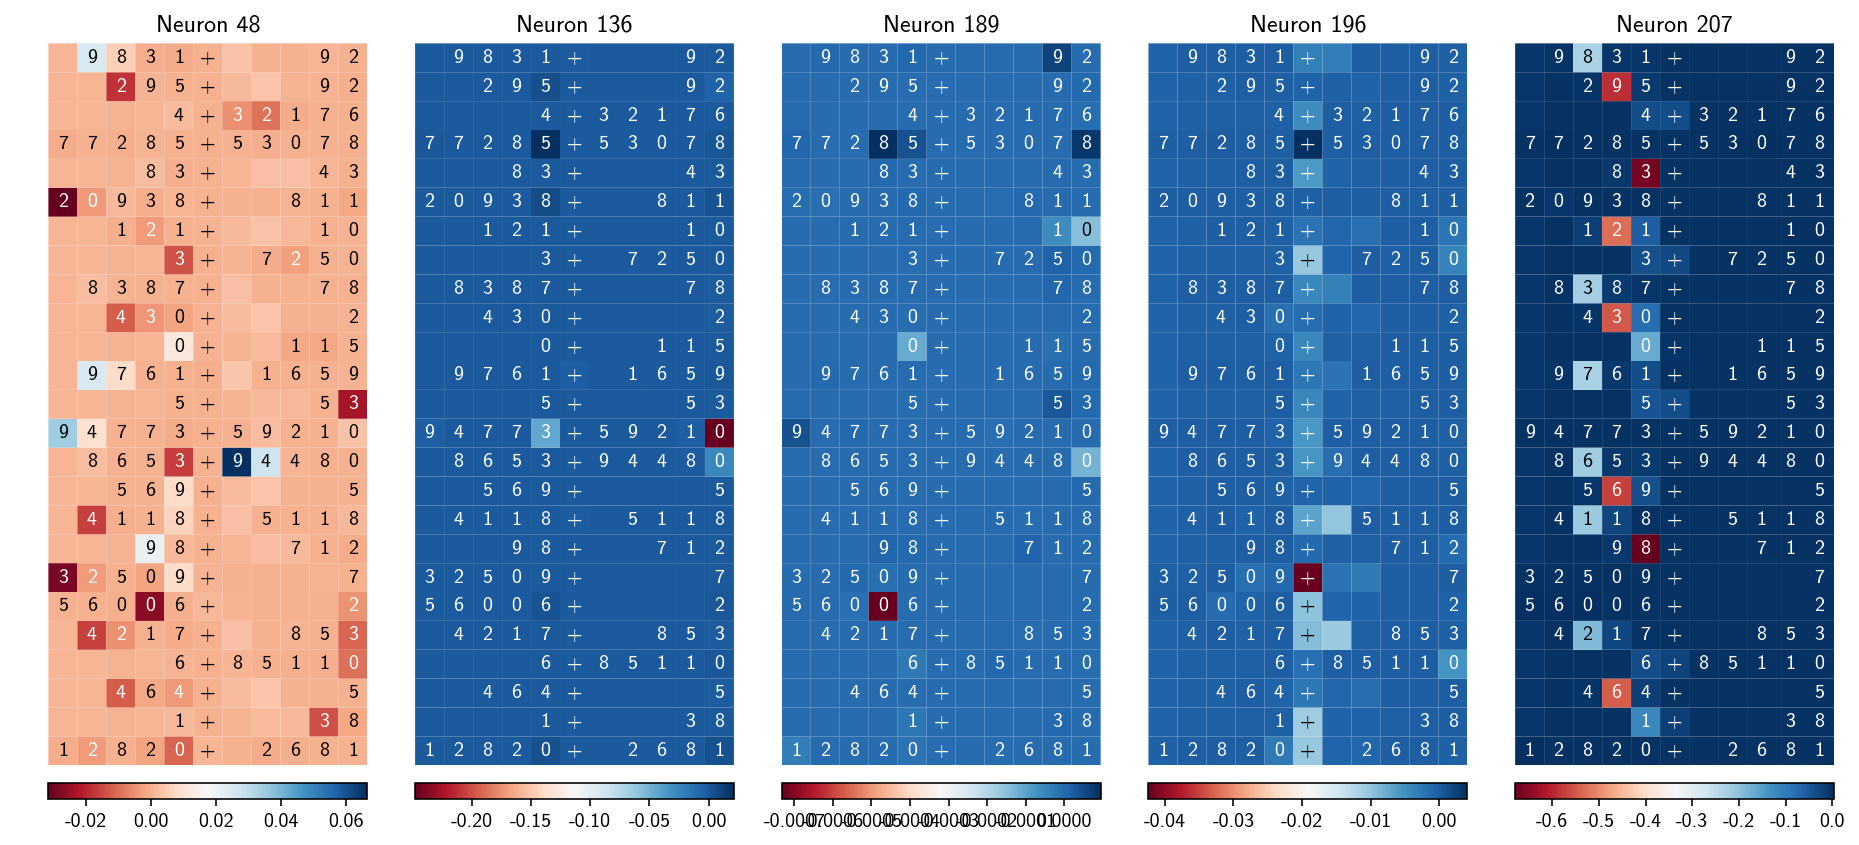

In [19]:
def plot_activation(neuron_idx, title=None, num_examples=25):
    c = plt.pcolor(encoder_activations[:num_examples, :, neuron_idx], edgecolors='k', linewidths=0, cmap='RdBu')
    if title:
        plt.title(title)
        
    def show_values(pc, texts, **kw):
        from itertools import izip
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, char in izip(pc.get_paths(), pc.get_facecolors(), texts):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, char, ha="center", va="center", color=color, **kw)
    
    plt.colorbar(c, orientation='horizontal', pad=0.02)
    show_values(c, ''.join(X_new[:num_examples]))
    plt.tight_layout()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 5)
gs.update(wspace=0.15, hspace=0)

for i, num in enumerate([48, 136, 189, 196, 207]):
    plt.subplot(gs[i])
    plot_activation(num, title='Neuron %d' % num)
    plt.axis('off')

fig.savefig('/home/bvt5/Downloads/encoder-neurons.png', dpi=600, bbox_inches='tight')

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())